In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

In [ ]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

,Días,Área,PY_VC_PCA,Valor_Proyecto
#,,,,
1,0.199969,-0.224328,-0.670771,-0.563421
2,0.199969,-0.224328,-0.670771,-0.545120
3,0.199969,-0.222966,-0.670771,-0.544601
4,0.199969,-0.222966,-0.670771,-0.532932
5,1.478731,-0.182279,-0.670771,-0.532623
...,...,...,...,...
121,-0.699160,-0.219754,-1.883419,-0.617652
122,-0.659199,-0.223679,-1.883419,-0.604545
123,-0.579276,-0.224410,-1.883419,-0.584883


In [ ]:
PY_DATOS_REALES_EST_SA.describe()

,Días,Área,PY_VC_PCA,Valor_Proyecto
count,115.000000,115.000000,115.000000,115.000000
mean,-0.082193,-0.098454,-0.089025,-0.097465
std,0.780387,0.605987,1.861373,0.706249
min,-0.918948,-0.224417,-1.932311,-0.682176
25%,-0.669189,-0.224096,-1.883419,-0.587202
50%,-0.359489,-0.222363,-0.670771,-0.410561
75%,0.219950,-0.203633,0.739387,0.150954
max,3.576699,4.300396,3.524117,2.571424


In [ ]:
# prompt: mediana de los datos reales

mediana = PY_DATOS_REALES_EST_SA.median()
print(mediana)

Días             -0.359489
Área             -0.222363
PY_VC_PCA        -0.670771
Valor_Proyecto   -0.410561
dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, units_3, units_4, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Mantener el resto del código igual
    model.compile(optimizer=RMSprop(learning_rate), #---------------------------------
                  loss='mean_squared_error',                                #--------------------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,                      #-----------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, units_3, units_4, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, units_3, units_4, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'units_3': (5, 100),
    'units_4': (5, 100),
    'learning_rate': (0.0001, 0.01)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=20, n_iter=20) #------------------------ 20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))
best_params['units_3'] = int(round(best_params['units_3']))
best_params['units_4'] = int(round(best_params['units_4']))

print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['units_3'],
    best_params['units_4'],
    best_params['learning_rate']
)

Output hidden; open in https://colab.research.google.com to view.

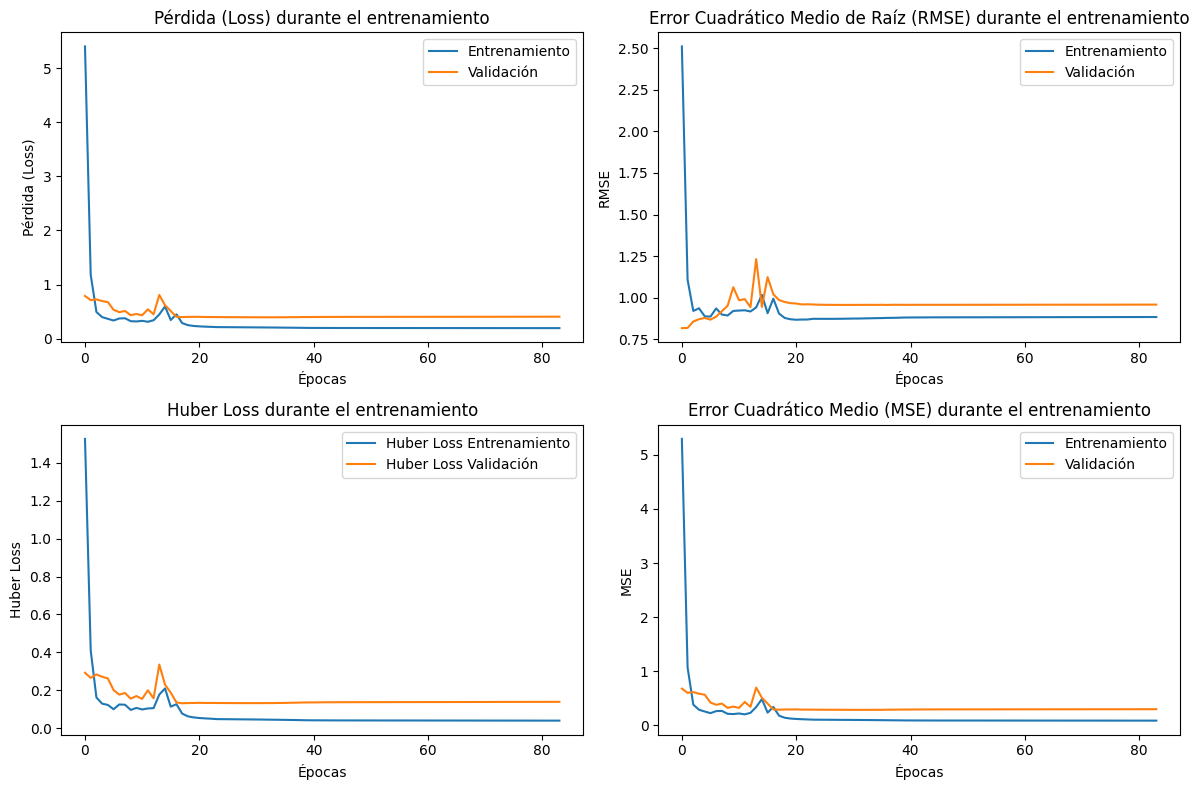

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


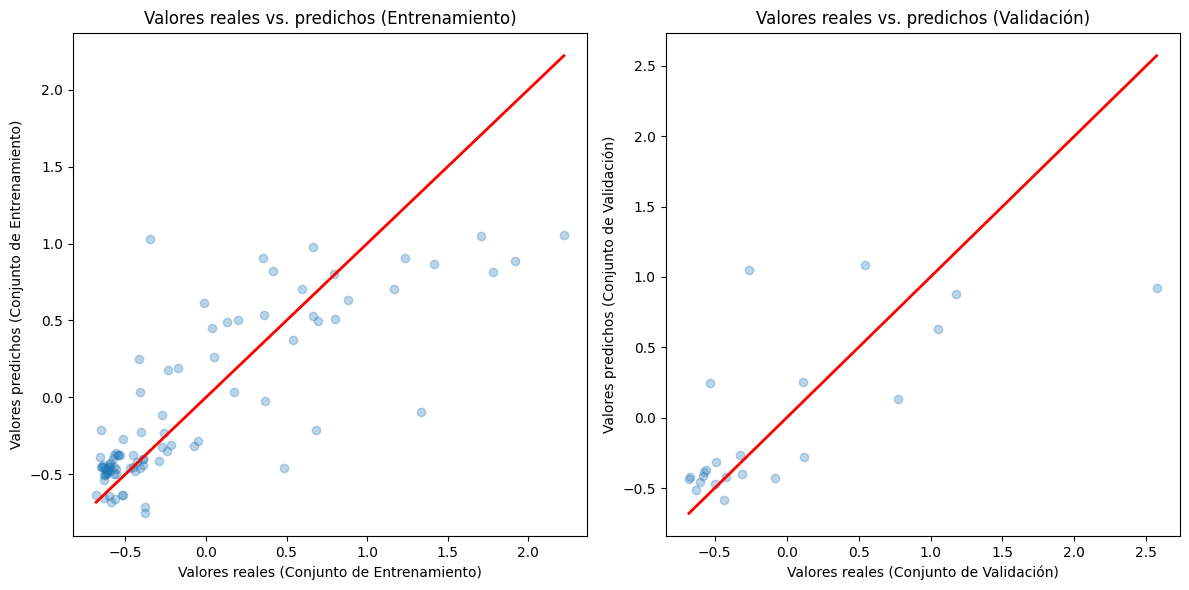


Métricas de entrenamiento:
MSE: 0.15628873108479358
RMSE: 0.3953336958631196
MAE: 0.26829325550866884
R^2: 0.6639405153500211
Correlación de Pearson: 5.73520930223774e-16
Correlación de Spearman: 0.7777225491508979
SSE: 6265.011104505493
SAE: 5316.538915569192
Media del error: -0.002401390484650196
Desviación estándar del error: 0.8603425521892257
Huber Loss (Entrenamiento): 0.04058456048369408

Métricas de validación:
MSE: 0.28890927036819997
RMSE: 0.5375028096374939
MAE: 0.36217267339008274
R^2: 0.5263143287244798
Correlación de Pearson: -3.355976804302457e-17
Correlación de Spearman: 0.7035573122529645
SSE: 484.2629423417186
SAE: 358.36663948554485
Media del error: -0.015275479936782594
Desviación estándar del error: 0.9566595803148574
Huber Loss (Validación): 0.1396676003932953
El punto de convergencia (mejor epoch): 34


In [ ]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['rmse'], label='Entrenamiento')
plt.plot(history.history['val_rmse'], label='Validación')
plt.title('Error Cuadrático Medio de Raíz (RMSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3, label='Datos')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2, label='Línea ideal')
plt.title('Valores reales vs. predichos (Entrenamiento)')
plt.xlabel('Valores reales (Conjunto de Entrenamiento)')
plt.ylabel('Valores predichos (Conjunto de Entrenamiento)')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3, label='Datos')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2, label='Línea ideal')
plt.title('Valores reales vs. predichos (Validación)')
plt.xlabel('Valores reales (Conjunto de Validación)')
plt.ylabel('Valores predichos (Conjunto de Validación)')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

In [ ]:
# prompt: imprimir todos los datos reales y predichos del conjunto de entrenamiento y validación con ID de PY_DATOS_REALES_EST_SA

# Crear un DataFrame con los datos reales y predichos del conjunto de entrenamiento
df_train_results = pd.DataFrame({
    'ID': PY_DATOS_REALES_EST_SA.index[:len(y_train)],
    'Valor_Proyecto_Real': y_train,
    'Valor_Proyecto_Predicho': y_train_pred.flatten()
})

# Crear un DataFrame con los datos reales y predichos del conjunto de validación
df_val_results = pd.DataFrame({
    'ID': PY_DATOS_REALES_EST_SA.index[len(y_train):],
    'Valor_Proyecto_Real': y_val,
    'Valor_Proyecto_Predicho': y_val_pred.flatten()
})

# Imprimir los resultados del conjunto de entrenamiento
print("Resultados del conjunto de entrenamiento:")
print(df_train_results)

# Imprimir los resultados del conjunto de validación
print("\nResultados del conjunto de validación:")
print(df_val_results)

Resultados del conjunto de entrenamiento:
     ID  Valor_Proyecto_Real  Valor_Proyecto_Predicho
0     1            -0.517863                -0.632624
1     2            -0.290855                -0.416149
2     3             1.236168                 0.907436
3     4            -0.597991                -0.436324
4     5            -0.589521                -0.682205
..  ...                  ...                      ...
87   98            -0.578329                -0.400566
88   99             1.706568                 1.046190
89  100             0.662780                 0.529064
90  101             0.359609                 0.532353
91  102            -0.604521                -0.455136

[92 rows x 3 columns]

Resultados del conjunto de validación:
     ID  Valor_Proyecto_Real  Valor_Proyecto_Predicho
0   103             0.116898                 0.256133
1   104            -0.532623                 0.249441
2   105            -0.434747                -0.583125
3   106             0.121810   

In [ ]:
Valor_Real_Predicho = df_val_results.to_excel("/content/drive/MyDrive/Datos/Valores reales vs predichos modelo 3-D-1.xlsx", sheet_name='VR vs VP_3-D-1')

In [ ]:
# prompt: concatenar el Valor_Proyecto_Predicho de entrenamiento y prueba

# Concatenar los valores predichos de entrenamiento y validación
y_pred_all = np.concatenate((y_train_pred, y_val_pred), axis=0)

# Crear un DataFrame con los valores predichos para todos los datos
df_all_results = pd.DataFrame({
    'ID': PY_DATOS_REALES_EST_SA.index,
    'Valor_Proyecto_Predicho': y_pred_all.flatten()
})

# Imprimir el DataFrame con los valores predichos
print("\nResultados para todos los datos:")
print(df_all_results)


Resultados para todos los datos:
      ID  Valor_Proyecto_Predicho
0      1                -0.632624
1      2                -0.416149
2      3                 0.907436
3      4                -0.436324
4      5                -0.682205
..   ...                      ...
110  121                -0.455136
111  122                 0.923170
112  123                 0.131405
113  124                -0.414084
114  125                 0.628518

[115 rows x 2 columns]


In [ ]:
Valor_Predicho = df_all_results.to_excel("/content/drive/MyDrive/Datos/Valores predichos modelo 3-D-1.xlsx", sheet_name='VP_3-D-1')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


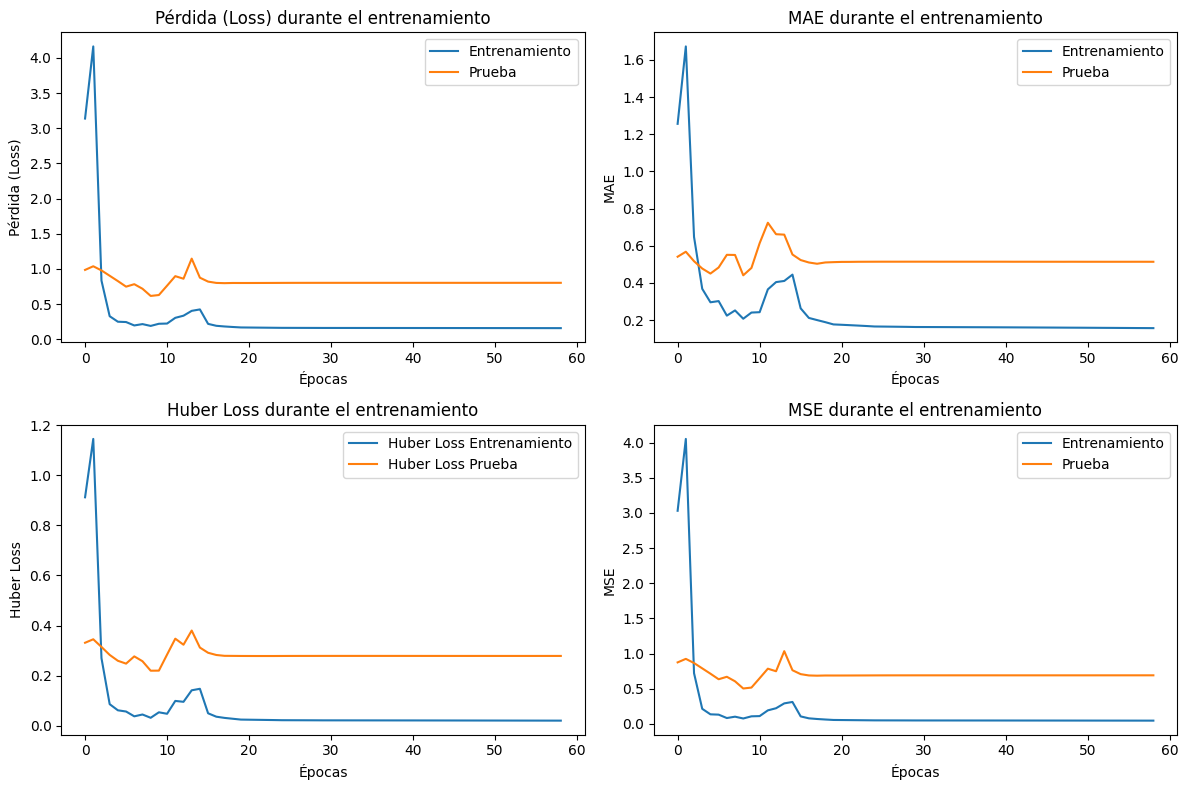

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


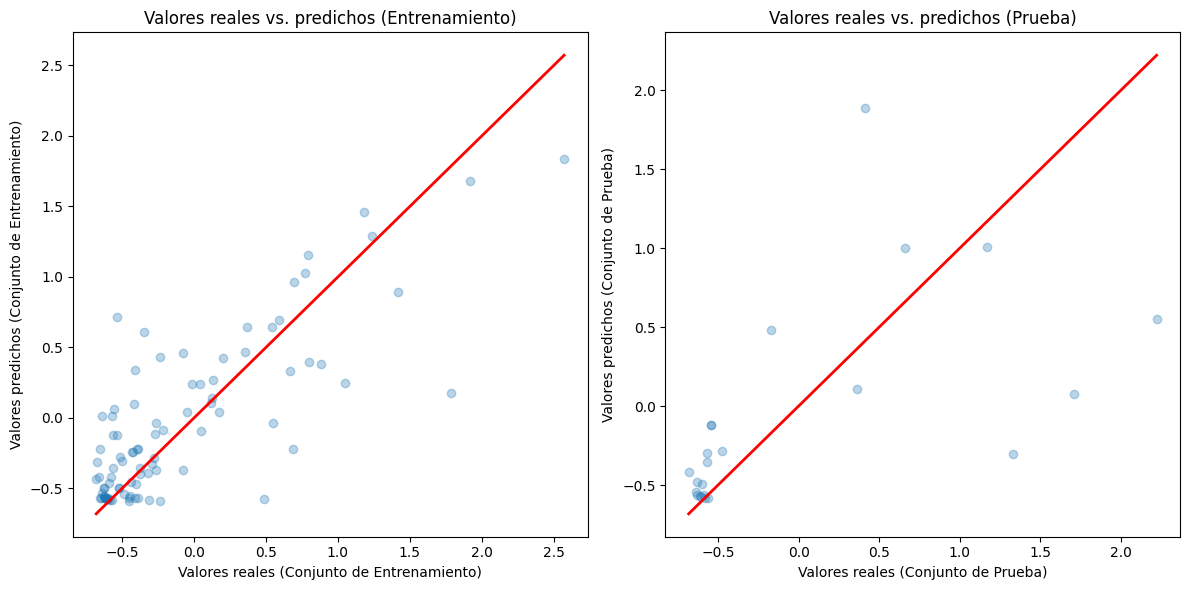

Métricas promedio para el conjunto de entrenamiento:
MSE: 0.2683649677027432
RMSE: 0.5072860819543938
MAE: 0.3335130606471327
SSE: 6442.873587609539
SAE: 5270.532919150975
R²: 0.471094612553218
Pearson: 1.783523889952057e-16
Spearman: 0.6362687936272055
Huber Loss: 0.03848057687282562
Métricas promedio para el conjunto de prueba:
Simulación de cross_val_score (MSE): 0.2654655559635839 ± 0.12678113181315587
Simulación de cross_val_score (RMSE): 0.5026132086615442 ± 0.1133380714611417
Simulación de cross_val_score (MAE): 0.343668866522735 ± 0.05669866366971503
SSE promedio: 407.25417288206376
SAE promedio: 326.9459153570587
R^2 promedio: 0.4349029389548681, Desviación estándar: 0.20395322769132543
Correlación de Pearson promedio: -3.3392180243522336e-18, Desviación estándar: 2.3475692188062217e-16
Correlación de Spearman promedio: 0.572879150918819, Desviación estándar: 0.16719898027823096
Huber Loss promedio: 0.16795700937509536, Desviación estándar: 0.0679470469650683
El punto de conve

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

mse_scores_train = []
mae_scores_train = []
sse_scores_train = []
sae_scores_train = []
r2_scores_train = []
pearson_scores_train = []
rmse_scores_train = []
spearman_scores_train = []
huber_loss_scores_train = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por SELU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por SELU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_3']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por SELU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_4']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por SELU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    # Función para calcular RMSE
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model.compile(optimizer=RMSprop(best_params['learning_rate']), #-----------------------------
                  loss='mean_squared_error',              #-----------------------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #--------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,                              #--------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir en el conjunto de entrenamiento y validación
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Calcular las métricas para el conjunto de entrenamiento
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    sse_train = np.sum((y_train - y_train_pred) ** 2)
    sae_train = np.sum(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
    spearman_train, _ = spearmanr(y_train, y_train_pred)
    huber_loss_train = history.history['huber_loss'][-1]

    # Almacenar las métricas para el conjunto de entrenamiento
    mse_scores_train.append(mse_train)
    rmse_scores_train.append(rmse_train)
    mae_scores_train.append(mae_train)
    sse_scores_train.append(sse_train)
    sae_scores_train.append(sae_train)
    r2_scores_train.append(r2_train)
    pearson_scores_train.append(pearson_train)
    spearman_scores_train.append(spearman_train)
    huber_loss_scores_train.append(huber_loss_train)

    # Calcular las métricas para el conjunto de validación (como ya lo tienes)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    sse_val = np.sum((y_val - y_val_pred) ** 2)
    sae_val = np.sum(np.abs(y_val - y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)
    pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
    spearman_val, _ = spearmanr(y_val, y_val_pred)
    huber_loss_val = history.history['val_huber_loss'][-1]

    # Almacenar las métricas para el conjunto de validación
    mse_scores.append(mse_val)
    rmse_scores.append(rmse_val)
    mae_scores.append(mae_val)
    sse_scores.append(sse_val)
    sae_scores.append(sae_val)
    r2_scores.append(r2_val)
    pearson_scores.append(pearson_val)
    spearman_scores.append(spearman_val)
    huber_loss_scores.append(huber_loss_val)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 3)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Prueba')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

# MSE
plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Valores reales vs. predichos (Entrenamiento)')
plt.xlabel('Valores reales (Conjunto de Entrenamiento)')
plt.ylabel('Valores predichos (Conjunto de Entrenamiento)')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Valores reales vs. predichos (Prueba)')
plt.xlabel('Valores reales (Conjunto de Prueba)')
plt.ylabel('Valores predichos (Conjunto de Prueba)')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Imprimir métricas de entrenamiento
print(f"Métricas promedio para el conjunto de entrenamiento:")
print(f"MSE: {np.mean(mse_scores_train)}")
print(f"RMSE: {np.mean(rmse_scores_train)}")
print(f"MAE: {np.mean(mae_scores_train)}")
print(f"SSE: {np.mean(sse_scores_train)}")
print(f"SAE: {np.mean(sae_scores_train)}")
print(f"R²: {np.mean(r2_scores_train)}")
print(f"Pearson: {np.mean(pearson_scores_train)}")
print(f"Spearman: {np.mean(spearman_scores_train)}")
print(f"Huber Loss: {np.mean(huber_loss_scores_train)}")


# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Métricas promedio para el conjunto de prueba:")
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")


# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")